In [1]:
# simulate a flux limited, and non-flux limited radio and IR survey
# from luminosity functions

In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from numpy import mean,sqrt

In [3]:
import sys # needed to import cat_utils
#sys.path.insert(0, '/Users/abrahamn/21cmIR/21cmIRxcor/')
sys.path.insert(0,'/home/ubuntu/21cmIRxcor')

import imp
import cat_utils
imp.reload(cat_utils)

<module 'cat_utils' from '/home/ubuntu/21cmIRxcor/cat_utils.pyc'>

In [4]:
# luminosity function of star forming galaxies at 1.4GHz
# Sec. 5.3 in Mauch & Sadler 2006, https://arxiv.org/abs/astro-ph/0612018v1

C_sf = 10.**(-2.83) # 1/(mag*Mpc^3)
Pstar_sf = 10.**(21.18) # W/Hz
alpha_sf = 1.02
sigma_sf = 0.6

numPbins_sf = 200
Pmin_sf,Pmax_sf = 1.e19,1.e24
Pedges_sf = 10.**np.linspace(np.log10(Pmin_sf),np.log10(Pmax_sf),numPbins_sf+1)
dP_sf = (Pedges_sf[1:]-Pedges_sf[:-1])
P_sf = .5*(Pedges_sf[1:]+Pedges_sf[:-1])

# rho_mag(mag) dmag = rho_L(L) dL  ==> rho_L(L) = rho_mag(mag(L)) dmag/dL = rho_mag(mag(L)) 2.5/L
# the above factor of 2.5/L is thus the factor needed to convert the magnitude luminosity functs in eqns. 5 and 6 in
# the above cited paper into power luminosity functions
def rho_P_sf(P):
    return (2.5/P)*C_sf*(P/Pstar_sf)**(1-alpha_sf)*np.exp(-.5*(np.log10(1+P/Pstar_sf)/sigma_sf)**2)*(Pmin_sf<P)*(P<Pmax_sf)

(1e+19, 1e+28)

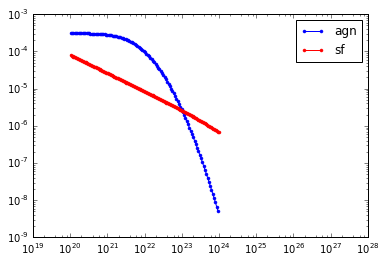

In [5]:
# luminosity function of AGN at 1.4GHz
# Sec. 5.3 in Mauch & Sadler 2006, https://arxiv.org/abs/astro-ph/0612018v1

C_agn = 10.**(-5.5) # 1/(mag*Mpc^3)
Pstar_agn = 10.**(24.59) # W/Hz
alpha_agn = 1.27
beta_agn = 0.49


numPbins_agn = 200
Pmin_agn,Pmax_agn = 1.e20,1.e27
Pedges_agn = 10.**np.linspace(np.log10(Pmin_agn),np.log10(Pmax_agn),numPbins_agn+1)
dP_agn = (Pedges_agn[1:]-Pedges_agn[:-1])
P_agn = .5*(Pedges_agn[1:]+Pedges_agn[:-1])

def rho_P_agn(P):
    return (2.5/P)*C_agn/((P/Pstar_agn)**alpha_agn+(P/Pstar_agn)**beta_agn)*(Pmin_agn<P)*(P<Pmax_agn)

plt.loglog(P_agn,rho_P_sf(P_agn)*dP_agn,'b.-',label='agn')
plt.loglog(P_sf,rho_P_agn(P_sf)*dP_sf,'r.-',label='sf')
plt.legend()
plt.xlim([1.e19,1.e28])
#plt.ylim([1.e-9,1.e-2])

In [6]:
# let's try to simulate an image of SF and AGN
# want 20deg wide, let's simulate out to z=.5
# let's ignore K corrections for now
# let's ignore the expansion of the universe

zmax = .7
c_over_H0 = 4283. # Mpc
los_min_Mpc,los_max_Mpc = 20.,c_over_H0*zmax
Mpc2m = 1.e6*3.e16

fov_deg = 20.
fov_rad = fov_deg*np.pi/180
trans_Mpc = 1.*fov_rad*los_max_Mpc

In [7]:

labels = ['AGN','SF']
P = [P_agn,P_sf]
rho_P = [rho_P_agn,rho_P_sf]
dP = [dP_agn,dP_sf]
numPbins = [numPbins_agn,numPbins_sf]

L1_vals_per_bin = [[],[]]
thx_vals_per_bin = [[],[]]
thy_vals_per_bin = [[],[]]
dist_vals_per_bin = [[],[]]

L1_vals = [[],[]]
thx_vals = [[],[]]
thy_vals = [[],[]]
dist_vals = [[],[]]

for j in range(2):
    for i in range(numPbins[j]):
        mean_num_objects_in_bin = rho_P[j](P[j][i])*dP[j][i]*trans_Mpc**2*(los_max_Mpc-los_min_Mpc)

        num_objects_in_bin = np.random.poisson(mean_num_objects_in_bin)
        los_vals_Mpc = np.random.uniform(los_min_Mpc,los_max_Mpc,num_objects_in_bin)
        x_vals_Mpc = np.random.uniform(-trans_Mpc/2,trans_Mpc/2,num_objects_in_bin)
        y_vals_Mpc = np.random.uniform(-trans_Mpc/2,trans_Mpc/2,num_objects_in_bin)
        dists_Mpc = np.sqrt(x_vals_Mpc**2+y_vals_Mpc**2+los_vals_Mpc**2)

        thx = np.arctan(x_vals_Mpc/los_vals_Mpc)*180./np.pi
        thy = np.arctan(y_vals_Mpc/los_vals_Mpc)*180./np.pi

        jy_vals = P[j][i]/(4.*np.pi*(dists_Mpc*Mpc2m)**2)/1.e-29
        g = (np.abs(thx)<fov_deg/2)&(np.abs(thy)<fov_deg/2)

        L1_vals_per_bin[j].append(P[j][i]+np.zeros(np.sum(g)))
        thx_vals_per_bin[j].append(thx[g])
        thy_vals_per_bin[j].append(thy[g])
        dist_vals_per_bin[j].append(dists_Mpc[g])

        print('%d objects in L=%e bin with flux %f +/- %f mJy, %d with flux greater than 10mJy'%(num_objects_in_bin,P[j][i],np.median(jy_vals),np.std(jy_vals),np.sum(jy_vals[g]>2)))

    L1_vals[j] = np.concatenate(L1_vals_per_bin[j]).flatten()
    thx_vals[j] = np.concatenate(thx_vals_per_bin[j]).flatten()
    thy_vals[j] = np.concatenate(thy_vals_per_bin[j]).flatten()
    dist_vals[j] = np.concatenate(dist_vals_per_bin[j]).flatten()

    print('using %d sources'%(len(L1_vals[j])))

361802 objects in L=1.041963e+20 bin with flux 0.000374 +/- 0.006095 mJy, 0 with flux greater than 10mJy
347209 objects in L=1.129412e+20 bin with flux 0.000406 +/- 0.006307 mJy, 0 with flux greater than 10mJy
333600 objects in L=1.224200e+20 bin with flux 0.000438 +/- 0.007217 mJy, 0 with flux greater than 10mJy
320188 objects in L=1.326944e+20 bin with flux 0.000474 +/- 0.006452 mJy, 0 with flux greater than 10mJy
308067 objects in L=1.438310e+20 bin with flux 0.000515 +/- 0.007767 mJy, 0 with flux greater than 10mJy
295141 objects in L=1.559023e+20 bin with flux 0.000561 +/- 0.008836 mJy, 0 with flux greater than 10mJy
283822 objects in L=1.689867e+20 bin with flux 0.000605 +/- 0.010352 mJy, 0 with flux greater than 10mJy
273885 objects in L=1.831692e+20 bin with flux 0.000656 +/- 0.012001 mJy, 0 with flux greater than 10mJy
263737 objects in L=1.985420e+20 bin with flux 0.000714 +/- 0.013534 mJy, 1 with flux greater than 10mJy
253324 objects in L=2.152051e+20 bin with flux 0.000770

In [8]:
L2_vals = [np.random.choice(a=P[j],size=len(L1_vals[j]),p=rho_P[j](P[j])*dP[j]/np.sum(rho_P[j](P[j])*dP[j]),replace=True) for j in range(2)]

In [9]:
F1_vals = [L1_vals[j]/(4.*np.pi*(dist_vals[j]*Mpc2m)**2)/1.e-29 for j in range(2)]
F2_vals = [L2_vals[j]/(4.*np.pi*(dist_vals[j]*Mpc2m)**2)/1.e-29 for j in range(2)]

In [10]:
# plt.loglog(L1_vals[0],L2_vals[0],'.',alpha=.005)
# plt.title(labels[0])
# plt.figure()
# plt.loglog(L1_vals[1],L2_vals[1],'.',alpha=.005)
# plt.title(labels[1])

In [11]:
# np.min(L1_vals[1])/(4.*np.pi*(np.max(dist_vals[1])*Mpc2m)**2)/1.e-29

In [12]:
mjy_min = .1
print(np.sum(F1_vals[0]>mjy_min))
g = [(F1_vals[j]>mjy_min)|(F2_vals[j]>mjy_min) for j in range(2)]

cat1s = [cat_utils.Catalog(thx_vals[j][g[j]],thy_vals[j][g[j]],F1_vals[j][g[j]]) for j in range(2)]
cat2s = [cat_utils.Catalog(thx_vals[j][g[j]],thy_vals[j][g[j]],F2_vals[j][g[j]]) for j in range(2)]

128033


In [13]:
for j in range(2):
    print(j)
    gg = g[j]
    print np.mean((F1_vals[j]-np.mean(F1_vals[j]))*(F2_vals[j]-np.mean(F2_vals[j]))) / np.sqrt(np.mean((F1_vals[j]-np.mean(F1_vals[j]))**2)*np.mean((F2_vals[j]-np.mean(F2_vals[j]))**2))
    print np.mean((F1_vals[j][gg]-np.mean(F1_vals[j][gg]))*(F2_vals[j][gg]-np.mean(F2_vals[j][gg]))) / np.sqrt(np.mean((F1_vals[j][gg]-np.mean(F1_vals[j][gg]))**2)*np.mean((F2_vals[j][gg]-np.mean(F2_vals[j][gg]))**2))

0
0.000203773833335
-0.000402537294951
1
0.0807376303423
0.0497266073791


In [14]:
# np.mean(L1_vals[0]/dist_vals[0]**2)/1.e16

In [15]:
# np.mean(L1_vals[0])/np.mean(dist_vals[0]**2)/1.e16

In [16]:
# dtheta_deg = 5./60

# cat1imgs = []
# cat2imgs = []

# for j in range(2):
#     cat1img,counts = cat_utils.cat2img(cat1s[j],bound_cat=cat1s[j],dtheta_deg=dtheta_deg,verbose=True)
#     cat2img,counts = cat_utils.cat2img(cat2s[j],bound_cat=cat1s[j],dtheta_deg=dtheta_deg,verbose=True)
    
#     cat1imgs.append(cat1img)
#     cat2imgs.append(cat2img)

In [17]:
# lmin,lmax = 0,3000
# nbins = 10
# cols = ['r','b']

# plt.figure(figsize=(16,4))

# for j in range(2):
    
#     lbins,pspec1,pspec2,xspec,bin_counts = cat_utils.calc_xspec(cat1imgs[j],cat2imgs[j],dtheta_deg,nbins,lmin,lmax,\
#                                                                 hann=True,uselogbins=False)
#     c = xspec/np.sqrt(pspec1*pspec2)
#     dc = np.sqrt(.5*(1+c**2)/(bin_counts/4))
#     print(np.mean(c))

#     plt.subplot(131)
#     plt.loglog(lbins,pspec1,cols[j]+'.')
#     plt.ylim([1.e-7,1.e-5])

#     plt.subplot(132)
#     plt.loglog(lbins,pspec2,cols[j]+'.')
#     plt.ylim([1.e-7,1.e-5])

#     plt.subplot(133)
#     plt.errorbar(lbins+10*j,c,yerr=dc,fmt='o',color=cols[j],label=labels[j])
#     plt.gca().set_xscale('log')
#     plt.ylim([-.5,.5])
#     plt.xlim([80,1.e4])
#     plt.semilogx([1.e2,1.e4],[0,0],'k-')
#     if j == 1: plt.legend(fontsize=10)

# plt.savefig('sim_realistic_radio_survey_agn_sf_>%1.2fmjy.pdf'%mjy_min,bbox_inches='tight')

In [18]:
# for j in range(2):
#     print labels[j]+'\t'+str(np.mean((cat1imgs[j]-np.mean(cat1imgs[j]))*(cat2imgs[j]-np.mean(cat2imgs[j])))/np.sqrt(np.var(cat1imgs[j])*np.var(cat2imgs[j])))

In [19]:
# plt.hist(dist_vals[1],50)
# plt.plot(np.arange(3000),np.arange(3000)**2*.22,'r')

In [20]:
# plt.hist(dist_vals[1]**2,50)
# plt.plot(np.arange(0,1.e7,1000),360*np.sqrt(np.arange(0,1.e7,1000)),'r')

In [21]:
# a=plt.hist(np.log10(1./dist_vals[1]**2),150)
# plt.plot(np.linspace(-7.2,-5),1.e-4*(10.**np.linspace(-7.2,-5))**(-2.5+1),'r') # the +1 takes into account the changing bin size due to the log x-axis
# plt.xlim([-7.2,-5])
# plt.ylim([0,.04e8])

In [22]:
# plt.hist(dist_vals[1]**4,50)
# plt.plot(np.linspace(1.e5,4.e13,100),.7e9*(np.linspace(1.e5,4.e13,100)**(-.25)),'r')
# plt.ylim([0,1.e6])

In [34]:
alpha0,alpha1 = los_min_Mpc**2,los_max_Mpc**2
num_alpha = 1600
alpha_edges = 10.**np.linspace(np.log10(alpha0),np.log10(alpha1),num_alpha+1)
dalpha = alpha_edges[1:]-alpha_edges[:-1]
alpha = .5*(alpha_edges[1:]+alpha_edges[:-1])

In [35]:
numF = 100
Fedges = 10.**np.linspace(-5.5,4,numF+1)
dF = Fedges[1:]-Fedges[:-1]
F = .5*(Fedges[1:]+Fedges[:-1])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


[1.2717642006380685, 0.73660518612102954]
[0.059932837344072502, 0.00025335069870768259]


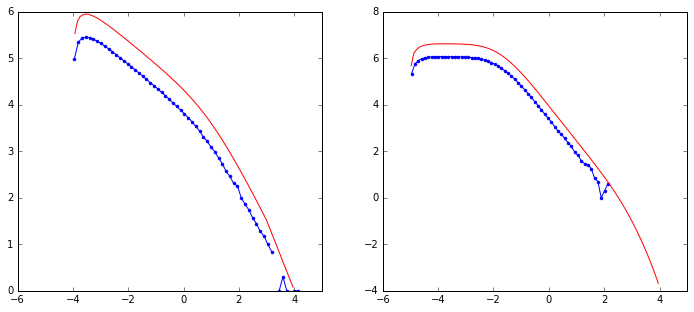

In [25]:
offsets = [16.5,16.5]
plt.figure(figsize=(12,5))
rho_F = [np.zeros(numF),np.zeros(numF)]
for j in range(2):
    for i in range(numF):
        for alphai in range(num_alpha):
            L = 1.e-29*4*np.pi*F[i]*alpha[alphai]*Mpc2m**2
            rho_F[j][i] += dalpha[alphai]*alpha[alphai]**1.5*rho_P[j](L)*dF[i]
    
    #rho_F1F2 = np.zeros(numF)
    
    plt.subplot(1,2,j+1)
    hist,bin_edges = np.histogram(np.log10(F1_vals[j]),60)
    bin_centers = .5*(bin_edges[1:]+bin_edges[:-1])
    plt.plot(bin_centers,np.log10(hist),'b.-')
    plt.plot(np.log10(F),np.log10(rho_F[j])+offsets[j],'r')
    plt.xlim([-6,5])
    
    Fmean = np.sum(rho_F[j]*F)*(1.e-29*4*np.pi*Mpc2m**2)/np.sum(rho_F[j])/1.e16
    Fmeansq = np.sum(rho_F[j]*F**2)*(1.e-29*4*np.pi*Mpc2m**2)**2/np.sum(rho_F[j])/1.e36
    
    print([Fmean,Fmeansq])
    

In [26]:
d0,d1 = los_min_Mpc,los_max_Mpc

a = (d1**3-d0**3)/(3*d1*d0*(d1-d0))

for j in range(2):
    Lmean = np.sum(rho_P[j](P[j])*dP[j]*P[j])/np.sum(rho_P[j](P[j])*dP[j])
    # np.mean(L1_vals[j]),Lmean
    L2mean = np.sum(rho_P[j](P[j])*dP[j]*P[j]**2)/np.sum(rho_P[j](P[j])*dP[j])
    # np.mean(L1_vals[j]**2),L2mean

    c = (a-1)/(a*L2mean/Lmean**2-1)
    
    #c2 = np.mean((F1_vals[j]-np.mean(F1_vals[j]))*(F2_vals[j]-np.mean(F2_vals[j])))/np.var(F1_vals[j])
    f1,f2 = F1_vals[j],F2_vals[j]
    L1,L2 = L1_vals[j],L2_vals[j]
    d = dist_vals[j]
    
    c2 = (mean(f1*f2)-mean(f1)**2)/(mean(f1**2)-mean(f1)**2)
    #c2 = (mean(L1*L2)*mean(1./d**4)-mean(L1)**2*mean(1./d**2)**2)/(mean(L1**2)*mean(1./d**4)-mean(L1)**2*mean(1./d**2)**2)

    print('correlation for %s is %1.4f, and the monte carlo gives %1.4f'%(labels[j],c,c2))

correlation for AGN is 0.0005, and the monte carlo gives 0.0003
correlation for SF is 0.0694, and the monte carlo gives 0.0777


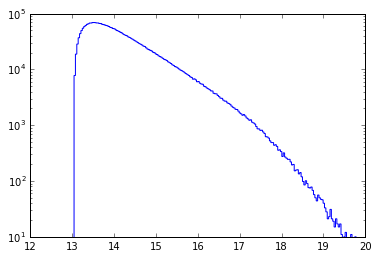

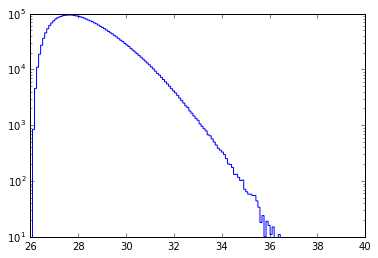

In [27]:
a=plt.hist(np.log10(L1_vals[0]/dist_vals[0]**2),250,histtype='step',color='blue')
plt.gca().set_yscale('log')
plt.xlim([12,20])
plt.figure()
a=plt.hist(np.log10(L1_vals[0]*L2_vals[0]/dist_vals[0]**4),150,histtype='step',color='blue')
plt.gca().set_yscale('log')

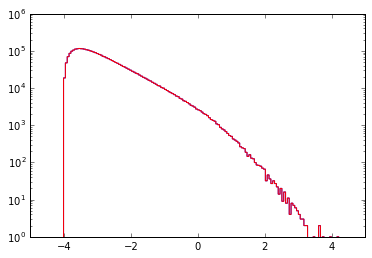

In [28]:
a=plt.hist(np.log10(L1_vals[0]/dist_vals[0]**2*1.e29/(4.*np.pi*Mpc2m**2)),150,histtype='step',color='blue')
a=plt.hist(np.log10(F1_vals[0]),150,histtype='step',color='red')
plt.gca().set_yscale('log')

In [36]:
numy = 1600
yedges = 10.**np.linspace(12,21,numy+1)
dy = yedges[1:]-yedges[:-1]
y = .5*(yedges[1:]+yedges[:-1])

numz = 1600
zedges = 10.**np.linspace(24,39,numz+1)
dz = zedges[1:]-zedges[:-1]
z = .5*(zedges[1:]+zedges[:-1])

In [ ]:
# calculate the correlations for the flux-limited case
# z refers to L1*L2/d^4
# y refers to L/d^2
# alpha refers to d^2
# beta refers to d^4

# these are the values if sources above flux F are neglected (eg, masked in an image analysis)
ymean = np.zeros((2,numF))
y2mean = np.zeros((2,numF))
zmean = np.zeros((2,numF))
y_to_mJy = 1.e29/(4*np.pi*Mpc2m**2)

for j in range(2):
    norm1 = np.zeros(numF)
    norm2 = np.zeros(numF)

    for ai in range(num_alpha):
        if ai % 10 == 0: print(1.*ai/num_alpha)
        
        for yi in range(numy):
            flux_bin_mask = F > y[yi]*y_to_mJy
            differential = dy[yi]*alpha[ai]**1.5*rho_P[j](y[yi]*alpha[ai])*dalpha[ai]
            ymean[j,flux_bin_mask] += y[yi]*differential
            y2mean[j,flux_bin_mask] += y[yi]**2*differential
            norm1[flux_bin_mask] += differential

        for zi in range(numz):
            for Li in range(numPbins[j]):
                flux_bin_mask = (F > P[j][Li]/alpha[ai]*y_to_mJy)&(F > z[zi]*alpha[ai]/P[j][Li]*y_to_mJy)
                differential = dalpha[ai]*dz[zi]*alpha[ai]**2.5*rho_P[j](P[j][Li])*rho_P[j](z[zi]*alpha[ai]**2/P[j][Li])*dP[j][Li]/P[j][Li]
                zmean[j,flux_bin_mask] += z[zi]*differential
                norm2[flux_bin_mask] += differential 
        
    ymean[j,:] /= norm1
    y2mean[j,:] /= norm1
    zmean[j,:] /= norm2

#    print([ymean[j]/1.e16,y2mean[j]/1.e36,zmean[j]/1.e33])

0.0
0.00625
0.0125
0.01875
0.025
0.03125
0.0375
0.04375
0.05
0.05625
0.0625
0.06875
0.075
0.08125
0.0875
0.09375
0.1
0.10625
0.1125
0.11875
0.125
0.13125
0.1375
0.14375
0.15
0.15625
0.1625
0.16875
0.175
0.18125
0.1875
0.19375
0.2
0.20625
0.2125
0.21875
0.225
0.23125
0.2375
0.24375
0.25
0.25625
0.2625
0.26875
0.275


In [ ]:
import pickle
pickle.dump([ymean,y2mean,zmean,{'num_alpha':num_alpha,'numy':numy,'numz':numz,'num_F':num_F}], open("/home/ubuntu/21cmIRxcor/fg_xcor/ymean_y2mean_zmean_for_agn_and_sf.p", "wb" ) )

In [ ]:
plt.semilogx(F,zmean[1,:],'.-')
plt.semilogx(F,ymean[1,:]**2,'.-')
#plt.xlim([.005,.04])
plt.ylim([0.e28,4.e28])
plt.xlim([.001,.02])

In [ ]:
j=1
plt.semilogx(F,(zmean[j,:]-ymean[j,:]**2),'.-')
plt.ylim([-.1e28,.2e28])
plt.xlim([.001,.02])

In [ ]:
cols = ['r','b']
matplotlib.rcParams.update({'font.size': 16})
for j in range(2):
    c = (zmean[j,:]-ymean[j,:]**2)/(y2mean[j,:]-ymean[j,:]**2)
    plt.semilogx(F,c,cols[j]+'.-',label=labels[j])

plt.xlabel('source mask depth (mJy)')
plt.ylabel('c')
plt.legend(fontsize=12)
plt.ylim([-.1,.15])
# plt.xlim([.005,.011])
plt.title('nalpha=%d, numz=%d, numy=%d'%(num_alpha,numz,numy))

In [33]:
# num sources below mask

# I'm being lazy here counting the sources below each F instead of looking at rho_F which I calculated above
num_sources_below_F = [np.array([np.sum(F1_vals[j]<F[i])/len(F1_vals) for i in range(numF)]) for j in range(2)]

(10000.0, 20000000.0)

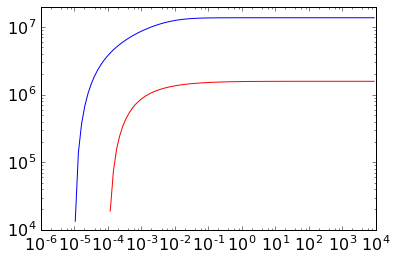

In [34]:
for j in range(2):
    plt.loglog(F,num_sources_below_F[j],cols[j],label=labels[j])
    
plt.ylim([1.e4,2.e7])

In [35]:

F0 = 1.e-2
for j in range(2):
    f1,f2 = F1_vals[j],F2_vals[j]
    g = (f1<F0)&(f2<F0)
    f1,f2 = f1[g],f2[g]
    
    print("%e, %e, %e"%(np.mean(f1)/y_to_mJy,np.mean(f1**2)/y_to_mJy**2,np.mean(f1*f2)/y_to_mJy**2))
    
    c = (mean(f1*f2)-mean(f1)**2)/(mean(f1**2)-mean(f1)**2)
    
    print(c)

1.567662e+14, 7.034090e+28, 2.758288e+28
0.0657102285323
1.370670e+14, 6.803885e+28, 1.975147e+28
0.0195750019313


In [36]:
Fi = int(148./4)
j = 1
print("%e, %e, %e"%(ymean[j,Fi],y2mean[j,Fi],zmean[j,Fi]))
(zmean[j,Fi]-ymean[j,Fi]**2)/(y2mean[j,Fi]-ymean[j,Fi]**2)

2.004413e+14, 1.068823e+29, 2.906741e+28


-0.16654264225062443

(3.5, 6.5)

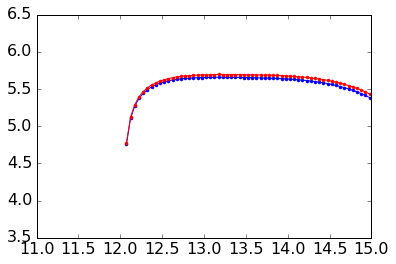

In [37]:
j=1
g = (F1_vals[j]<F0)&(F2_vals[j]<F0)
hist,bin_edges = np.histogram(np.log10(F1_vals[j][g]/y_to_mJy),60)
bin_centers = .5*(bin_edges[1:]+bin_edges[:-1])
plt.plot(bin_centers,np.log10(hist),'b.-')

g = (F1_vals[j]<F0)
hist,bin_edges = np.histogram(np.log10(F1_vals[j][g]/y_to_mJy),60)
bin_centers = .5*(bin_edges[1:]+bin_edges[:-1])
plt.plot(bin_centers,np.log10(hist),'r.-')

# plt.plot(np.log10(F),np.log10(rho_F)+offsets[j],'r')
# plt.xlim([-6,5])
plt.xlim([11,15])
plt.ylim([3.5,6.5])

In [ ]:
j = 1
y_to_mJy = 1.e29/(4*np.pi*Mpc2m**2)
rho_y = np.zeros(numF)
b = np.zeros(numF)
for yi in range(numy):
    for ai in range(num_alpha):
        rho_y[yi] += dy[yi]*alpha[ai]**1.5*rho_P[j](y[yi]*alpha[ai])*dalpha[ai]
        
        L = 1.e-29*4*np.pi*F[yi]*alpha[ai]*Mpc2m**2
        b[yi] += dF[yi]*alpha[ai]**1.5*rho_P[j](L)*dalpha[ai]
        
        if ai<5:
            print([y[yi],1.e-29*4*np.pi*F[yi]*Mpc2m**2])


In [ ]:
plt.semilogy(np.log10(y),rho_y*1e-17,'k')

plt.semilogy(np.log10(F/y_to_mJy),b,'r--')


#plt.plot(bin_centers,np.log10(hist),'b.-')

#plt.xlim([1.e11,1.e15])
#plt.ylim([1.e5,1.e8])
# plt.ylim([.1,10])
# plt.xlim([12,16])

In [40]:
for j in range(2):
    print([np.mean(L1_vals[j]/dist_vals[j]**2)/1.e16, np.mean((L1_vals[j]/dist_vals[j]**2)**2)/1.e36, np.mean(L1_vals[j]*L2_vals[j]/dist_vals[j]**4)/1.e33])
    print([np.mean(L2_vals[j]/dist_vals[j]**2)/1.e16, np.mean((L2_vals[j]/dist_vals[j]**2)**2)/1.e36])
    print

[1.2556660896800835, 1.0444331092420798, 2.3038294341944781]
[1.3878731337972114, 6.8354734027992992]

[0.058541115805731736, 0.00012334323574006526, 0.011262998376811179]
[0.058245838166190438, 9.248768412260302e-05]

